In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from misc import *

PrintGPUInfo()

Initialize turbulent phase screens generator for the VLT case so that $r_0$ is $\times 3$ oversampled.

In [ ]:
from phase_generator import *

# Parameters
D  = 8.0  # Size of the phase screen [m]
r0 = 0.125 # Fried parameter [m] @ λ_atm = 500 nm
L0 = 25.0 # Outer scale [m]

dx = r0 / 3 # Spatial sampling interval [m/pixel], make sure r0 is Nyquist sampled
dt = 0.001 # Time step [s/step]

screen_generator = PhaseScreensGenerator(D, dx, dt, batch_size=100, n_cascades=3, seed=142)

Initialize the atmospheric profile with 5 frozen-flow layers and add it to the screens generator. Initialize according to the von Kármán model and without boling (`boiling_factor = 0`).

In [ ]:
from atmospheric_layer import *

wind_directions = [90, 0, 45, 135, 270]
wind_speeds = [40, 20, 10, 5, 2]
weights = [0.6, 0.2, 0.1, 0.08, 0.02]

boiling_factor = 0

layers = []
for i in range(5):
    layer = Layer(weights[i], 0, wind_speeds[i], wind_directions[i], boiling_factor, 
                  lambda f: vonKarmanPSD(f, r0, L0), lambda f: SimpleBoiling(f, screen_generator.dx))
    screen_generator.AddLayer(layer)

print(screen_generator)

Run the simulation with benchmarking

In [ ]:
results = BenchmarkScreensGenerator(
    screen_generator,
    iters=1000,
    use_tqdm=True,
    verbose=True
)

screens_frozen = results["screens"]

To run simulation withou benchmarking, this code can be used. Note, that screens are generated in batches. When `t` runs out of the current batch, the new batch is generated.

In [ ]:
screens_sequence = []

N_screens = 1000
for i in tqdm(range(N_screens)):
    screens_sequence.append(screen_generator.GetScreenByTimestep(i))
    
screens_sequence = xp.dstack(screens_sequence).get()

Render the generated animation

In [ ]:
print(f"Generating animation from {screens_frozen.shape[2]} phase screens...")
RenderVideo(
    screens_frozen,
    max_frames=200,
    interval=30,
    frame_step=2,
    start=0,
    dt=dt,
    title=f'{len(screen_generator.layers)} layers frozen-flow'
)

Now, initialize the layer that combines boiling and frozen-flow. In the current version of code, boiling behaviour is still ad hoc, meaning that the boiling evolution law just assumes that low spatial frequencies evolve slower than high freqs. The units of `boiling_factor` remain arbitrary (to be studied in the future in more details).

In [ ]:
# Initialize a new phase screen generator instance
screen_generator = PhaseScreensGenerator(D, dx, dt, batch_size=100, n_cascades=3, seed=142)

boiling_factor = 200 # [a.u.]

# Initialize a layer with boiling enabled
boiling_layer = Layer(1.0, 0, 20.0, 45, boiling_factor, lambda f: vonKarmanPSD(f, r0, L0), lambda f: SimpleBoiling(f, screen_generator.dx))

screen_generator.AddLayer(boiling_layer)

# Simulate
results = BenchmarkScreensGenerator(
    screen_generator,
    iters=1000,
    use_tqdm=True,
    verbose=True
)

screens_boiling = results["screens"]

# Render the animation
print(f"Generating animation from {screens_boiling.shape[2]} phase screens...")
RenderVideo(
    screens_boiling,
    max_frames=200,
    interval=30,
    frame_step=2,
    start=0,
    dt=dt,
    title=f'{len(screen_generator.layers)} layers frozen-flow'
)

Initialize phase generator in the debug regime to reconstruct back the PSD from the simulated phase screens sequence.

In [48]:
# Parameters
D  = 8.0  # Size of the phase screen [m]
r0 = 0.1  # Fried parameter [m]
L0 = 25.0 # Outer scale [m]

dx = r0 / 3 # Spatial sampling interval [m/pixel], make sure r0 is Nyquist sampled
dt = 0.001 # Time step [s/step]

screen_generator = PhaseScreensGenerator(D, dx, dt, batch_size=100, n_cascades=3, seed=142, debug_flag=True)
screen_generator.AddLayer(Layer(1.0, 0, 15, 2, 100, lambda f: vonKarmanPSD(f, r0, L0), lambda f: SimpleBoiling(f, screen_generator.dx)))

screens_sequence = []
N_screens = 1000
for i in tqdm(range(N_screens)):
    screens_sequence.append(screen_generator.GetScreenByTimestep(i))
screens_sequence = xp.dstack(screens_sequence).get()

c:\Users\akuznets\Projects\FATMOSS\atmospheric_layer.py:22: UserWarning: Layer height is not yet implemented.
  self.weight = weight


GPU memory successfully deallocated.
Added layer 1: weight=1.000, wind_speed=15.0 m/s, wind_direction=2.0°


100%|██████████| 1000/1000 [00:01<00:00, 753.81it/s]


In [45]:
screens_sequence.max()
np.sqrt(70)

8.366600265340756

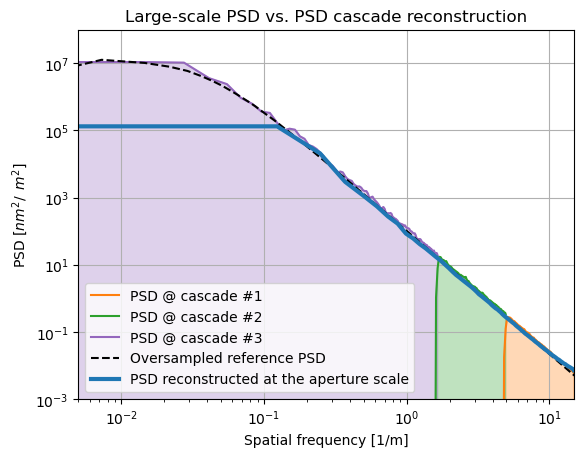

In [ ]:
PSDs_cascade = []

for i in range(screen_generator.n_cascades):
    phase_scr = screen_generator.raw_batch[...,i]
    PSD_ = PSD_to_phase(phase_scr)
    PSD_ = PSD_ * screen_generator.df[...,i]**2 * 9**(2*(i+1))
    PSD_[PSD_ < xp.median(PSD_)/4] = 1e-12 # Bottom threshold for a more beautiful display
    PSDs_cascade.append(PSD_.get() if GPU_flag else PSD_)

oversampling_factor = 17
_, _, f_over, df_over = screen_generator.freq_array(screen_generator.N*oversampling_factor, dx)

PSD_ultimate = vonKarmanPSD(f_over, r0, L0) * df_over**2 * oversampling_factor**2

PSD_out = PSD_to_phase(screens_sequence)

if GPU_flag:
    PSD_out = cp.asnumpy(PSD_out)

def radialize_PSD(PSD, grid, label='', plot=True, fill=False, **kwargs):
    PSD_profile  = radial_profile(PSD, (PSD.shape[0]//2, PSD.shape[1]//2))[:PSD.shape[1]//2]
    grid_profile = grid[grid.shape[0]//2, grid.shape[1]//2:-1]
    if plot:
        plt.plot(grid_profile, PSD_profile, label=label, **kwargs)
    if fill:
        plt.fill_between(grid_profile, PSD_profile, alpha=0.3, **kwargs)

    return PSD_profile

colors_ = ['tab:orange', 'tab:green', 'tab:purple', 'tab:pink', 'tab:olive', 'tab:cyan']


for i in range(screen_generator.n_cascades):
    _ = radialize_PSD(PSDs_cascade[i], screen_generator.f[...,i], label=f'PSD @ cascade #{i+1}', plot=True, fill=True, color=colors_[i])

_ = radialize_PSD(PSD_ultimate, f_over, 'Oversampled reference PSD', linewidth=1.5, color='black', linestyle='dashed')
_ = radialize_PSD(PSD_out, screen_generator.f[...,0], 'PSD reconstructed at the aperture scale', linewidth=3)

plt.grid()
plt.title('Large-scale PSD vs. PSD cascade reconstruction')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-3, 1e8])
plt.xlim([5e-3, 15])
plt.xlabel('Spatial frequency, [1/m]')
plt.ylabel(r'PSD, $[nm^2 / \hspace{0.5} m^2]$')
plt.show()